In [184]:
import random

#random.seed(420) # 8 errors
random.seed(1) # 13 errors

"""
- borrow_amount
- last_repaid
- total_staked
- total_locked
- staked

"""
overdue = 75
stakers = [{"staked_amount": random.randint(25 * 100, 35 * 100) } for i in range(25)]

for i in range(len(stakers)):
    borrowers = [{"borrow_amount": random.randint(1, 100), "last_repaid": random.randint(1, overdue * 2)} for i in range(25)]
    stakers[i]["borrowers"] = borrowers
    stakers[i]["locked"] = sum([borrower["borrow_amount"] for borrower in borrowers])
    stakers[i]["frozen"] = sum([borrower["borrow_amount"] if borrower["last_repaid"] > overdue else 0 for borrower in borrowers])
    
total_staked = sum([staker["staked_amount"] for staker in stakers])
total_borrowed = sum([sum([borrower["borrow_amount"] for borrower in staker["borrowers"]]) for staker in stakers])
total_frozen = sum([staker["frozen"] for staker in stakers])

print(f"total_staked: {total_staked}")
print(f"total_borrowed: {total_borrowed}")
print(f"total_frozen: {total_frozen}")

total_staked: 75076
total_borrowed: 31730
total_frozen: 16668


In [185]:
"""
Calculate multipliers the old way

function _getRewardsMultiplier(
    uint256 userStaked,
    uint256 lockedStake,
    uint256 totalFrozen_,
    bool isMember_
) private pure returns (uint256) {
    if (!isMember_) {
        return nonMemberRatio;
    }
        
    if (userStaked == 0 || totalFrozen_ >= lockedStake || totalFrozen_ >= userStaked) {
        return memberRatio;
    }

    uint256 effectiveLockedAmount = lockedStake - totalFrozen_;
    uint256 effectiveStakeAmount = userStaked - totalFrozen_;

    uint256 lendingRatio = effectiveLockedAmount.wadDiv(effectiveStakeAmount);

    return lendingRatio + memberRatio;
}

"""
member_ratio = 1

def getRewardsMultiplier(staked, locked_stake, frozen_stake):
    if staked == 0 or frozen_stake >= locked_stake or frozen_stake >= staked:
        return member_ratio
    
    effective_locked_amount = locked_stake - frozen_stake
    effective_stake_amount = staked - frozen_stake
    
    lending_ratio = effective_locked_amount / effective_stake_amount
    
    return lending_ratio + member_ratio

for staker in stakers:
    staker["old_multiplier"] = getRewardsMultiplier(staker["staked_amount"], staker["locked"], staker["frozen"])

In [186]:
"""
Calculate multipliers the new way

1 2 3 4 5 6 7 8 9
    |   |       |
    
(5 - 3) / (9 - 3) = 0.16666
"""
import math

# first we calculate each stakers coinage
for staker in stakers:
    staker["coinage"] = sum([borrower["borrow_amount"] / borrower["last_repaid"] for borrower in staker["borrowers"]])

total_coinage = sum([staker["coinage"] for staker in stakers])
print(f"total_coinage: {total_coinage}")

def getRewardsMultiplierNew(coinage):
    ave_coinage = total_coinage / len(stakers)
    lo = ave_coinage - (ave_coinage / 2)
    hi = ave_coinage + (ave_coinage / 2)
    coinage = min(max(lo, coinage), hi)
    
    k =  0.5 * ((coinage - lo) / (hi - lo))
    return 1 + k
    
for staker in stakers:
    staker["new_multiplier"] = getRewardsMultiplierNew(staker["coinage"])

total_coinage: 1249.640840030525


errors: 13
staked: 3367, locked: 1209, frozen: 1209
staked: 3321, locked: 1233, frozen: 1233
staked: 3282, locked: 985, frozen: 985
staked: 2564, locked: 1039, frozen: 1039
staked: 3279, locked: 1219, frozen: 1219
staked: 2960, locked: 1421, frozen: 1421
staked: 2983, locked: 1140, frozen: 1140
staked: 3167, locked: 1331, frozen: 1331
staked: 2714, locked: 1571, frozen: 1571
staked: 2596, locked: 1304, frozen: 1304
staked: 2529, locked: 1477, frozen: 1477
staked: 2899, locked: 1379, frozen: 1379
staked: 2943, locked: 1474, frozen: 1474


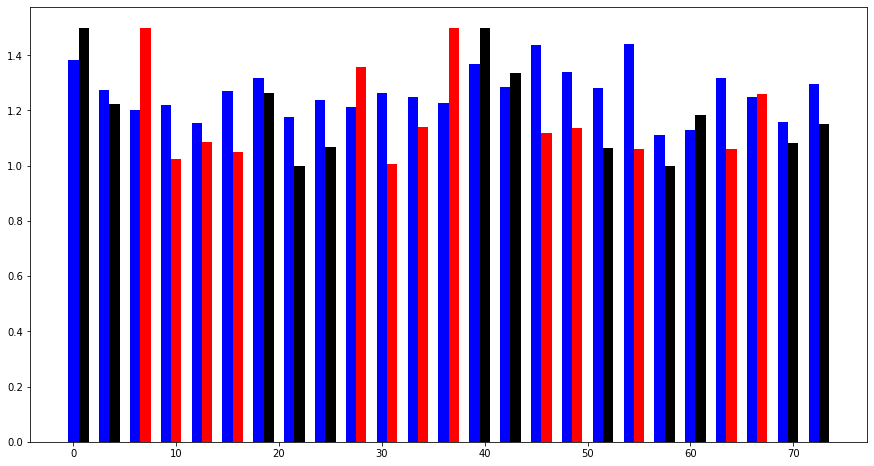

In [187]:
import matplotlib.pyplot as plt

debug = False
plt.figure(figsize=(15,8))

errors=[]

for i in range(0, len(stakers) * 3, 3):
    idx = int(i/3)
    
    old = stakers[idx]['old_multiplier']
    old_b = stakers[idx-1]['old_multiplier']

    new = stakers[idx]['new_multiplier']
    new_b = stakers[idx-1]['new_multiplier']
    
    color="black"
    if (old > old_b and new < new_b) or (old < old_b and new > new_b):
        errors.append(stakers[idx])
        color="red"
            
    plt.bar(i, old, 1, color="blue")
    plt.bar(i+1, new, 1, color=color)
    if debug:
        print("------")
        print(f"old_multiplier: {staker['old_multiplier']}")
        print(f"new_multiplier: {staker['new_multiplier']}")

print(f"errors: {len(errors)}")
for error in errors:
    print(f"staked: {error['staked_amount']}, locked: {error['locked']}, frozen: {error['locked']}")